# Redes Neurais Artificiais, Tensorflow e Keras

No contexto de modelagem e aprendizado de máquina, as [redes neurais artificiais profundas](https://pt.wikipedia.org/wiki/Aprendizagem_profunda) vem tomando seu lugar no estado de arte como tecnicas de modelagem extremamente poderosas. Suas propriedaes intrínsecas permitem a estas estruturas aprenderem representações hierarquicas de alto nível baseadas nos dados de treinamento. Esta capacidade torna as redes neurais profundas ótimas estruturas de compressão de dados, com possibilidade de otimização utilizando propagação reversa dos gradientes (modelo diferenciavel), o que torna o seu treinamento eficiente e de rápida convergencia.

O Tensorflow é uma biblioteca da Google com *bindings* em Python, capaz de gerar e computar grafos matemáticos com altíssima eficiência. Esta biblioteca poderosíssima esta em constante evolução e vem sendo empregada em todos os setores da indústria.

O Keras nada mais é do que um modulo de alto nível por cima do Tensorflow, muito bom para prototipagem rápida e implementação de redes neurais artificiais.

Nesta sessão faremos uso do Keras para implementar redes neurais artificiais e utiliza-las para fazer predições sobre problemas de *Supervised Learning*.

Vamos utilizar para demonstração o clássico dataset MNIST. Este conjunto de dados consiste em imagens de digitos manuscritos de 0 a 9, com os respectivos rótulos associados. Estes ultimos serão utilizados como sinal de supervisão. Nosso objetivo é aprender o mapeamento entre os pixels da imagem e a respectiva classe (0 a 9) ao qual aquele digito pertence.

Inicialmente, vamos carregar o banco de dados do repositório de exemplos do tensorflow.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Desta vez, vamos utilizar o *Mini Batch Stochastic Gradient Descent* como algoritmo de otimização. Esta tecnica utiliza amostras retiradas dos dados para calcular o gradiente do erro com relação aos parâmetros do modelo e realizar a atualização dos parâmetros. Para fazer isso, precisamos realizar a amostragem do *dataset* em *batches*. Por sorte o pessoal da Google ja deixou isso bem facilitado, e apenas chamar o método "next_batch()" no objeto *dataset* já faz o serviço. Vamos amostrar um *batch* para entender do que o banco de dados se trata.

In [4]:
batch = mnist.train.next_batch(3)
batch

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]))

In [5]:
print("Formato da amostra de variáveis de entrada: ",batch[0].shape)
print("Formato da amostra de variáveis alvo: ",batch[1].shape)

Formato da amostra de variáveis de entrada:  (3, 784)
Formato da amostra de variáveis alvo:  (3, 10)


Vemos que a amostra contém três figuras de 784 pixels em um array *C-ordered*, cada uma com sua respectiva classe codificada em um array *one-hot*. São três figuras pois este foi o argumento passado ao método "next_batch".

O array *one-hot* é um tipo de codificação para variáveis multiclasse muito útil, e indica que a amostra é da classe $ i $, sendo $i$ o indice do elemento do array onde o elemento é igual a 1, ou seja, um array do tipo [0,0,1,0,0,0,0,0,0,0], por exemplo, indica que a figura representa o número 2.

As figuras podem ser visualizadas com o código a seguir:

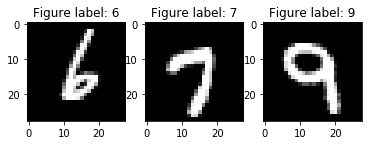

In [6]:
f, axarr = plt.subplots(1, batch[0].shape[0])

for i in range(batch[0].shape[0]):

    pixels = np.array(batch[0][i]) # carrega amostra na variavel pixels

    pixels = pixels.reshape((28, 28)) # redimensiona o array para 28x28 pixels

    # Plot
    axarr[i].set_title("Figure label: "+str(batch[1][i].nonzero()[0][0])) # define o titulo de cada imagem
    axarr[i].imshow(pixels, cmap='gray') # plota a imagem

plt.show() # mostra a figura

Para ilustrar o processo de codificar e treinar uma rede neural profunda em python, vamos utilizar o numpy como biblioteca matemática e fazer isto do rascunho para cima.

Iniciaremos declarando as funções auxiliares ao nosso processo.

- A primeira função define a estrutura do nosso modelo e inicializa suas variáveis. Uma grande variedade de inicializações pseudo-aleatórias dos pesos está disponível na literatura e o modo como se inicializa os pesos de uma rede neural profunda afeta como ela aprende. Este efeito é ligado principalmente ao fenomeno dos [*Vanishing Gradients*](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), ou gradientes que desaparecem. Mais sobre este assunto mais à frente. Aqui, inicializaremos nosos pesos com distribuição normal de média zero e variancia 0.1.

### Multilayer Perceptron

In [7]:
np.random.seed(42)                                                  # fixa a random seed para obter repetibilidade dos resultados

def mlp(n_in, n_hidden, n_out):                                     # Funçao de inicializaçao das variaveis da rede neural

    U = np.random.normal(size=(n_in, n_hidden))          # Pesos da primeira layer (Distribuiçao normal com desvio 0.1 e shape (n_in, n_hidden)
    V = np.random.normal(size=(n_hidden, int(n_hidden))) # O mesmo para a segunda layer
    W = np.random.normal(size=(int(n_hidden), n_out))    # pesos layer de saida

    bu = np.zeros(n_hidden)                                         # Inicializa bias da primeira layer
    bv = np.zeros(int(n_hidden))                                    # mesmo segunda layer
    bw = np.zeros(n_out)                                            # Bias de saída

    params = [U,V,W,bu,bv,bw]                                       # transforma os parametros em lista de parametros

    return params                                                   # retorna parametros

- A segunda função é a função de ativação dos neuronios a ser utilizada. Neste caso, usaremos a função sigmoid.

In [8]:
def sigmoid(x):                                                     # Funçao de ativação dos neurons
    out = []
    for i in range(x.shape[0]):                                     # faz a sigmoid de cada valor no array
        sig_i = 1.0 / (1.0 + np.exp(-x[i]))
        out.append(sig_i)                                           # adiciona o valor de saida da sig a uma lista
                                                                    # de valores para retornar
    return np.array(out)

- A terceira função é a função de propagação direta da nossa rede neural, e será usada para fazer inferência.

In [9]:
def predict(x, U, V, W, bu, bv, bw):    # Realiza prediçoes com a rede neural
    A = np.dot(x, U) + bu               # Calcula a saída da layer 1 sem ativaçao
    B = np.dot(sigmoid(A), V) + bv      # Calcula a saida da layer de dois sem ativaçao
    C = np.dot(sigmoid(B), W) + bw      # saida layer, saida sem ativaçao
    Z = sigmoid(C)                      # ativaçao layer saida
    index = np.argmax(Z)                # adquire o index no array de 1 a 10 que corresponde ao valor da prediçao
    out = np.zeros((1, 10))             # cria array de dez valores 0
    out[0, index] = 1                   # atribui valor 1 ao valor no array cujo index corresponde a saída da layer
    return Z, out.astype(int)           # retorna probabilidade de cada valor, prediçao em one-hot

- A quarta e última função é a função de propagação reversa da rede neural. Esta função trata de calcular os gradientes do erro em relação aos parâmetros do modelo. Utilizar estes gradientes para atualizar os pesos do modelo em questão é chamado *Gradient Descent*. Quando ele é feito em amostrar menores do *dataset*, ele se torna o *Stochastic Gradient Descent*.

In [10]:
def train(x, y, U, V, W, bu, bv, bw): #funçao treinamento

    """
    PARAMETROS: x = input data
            V =  Pesos da primeira layer
            W =  Pesos da segunda layer
            bv = Bias da primeiralayer
            bw = Bias da segunda layer

    """

    t = np.transpose(y) # transpoe a matriz de entrada para realizar as multiplicaçoes matriciais

    # forward propagation
    A = np.dot(x, U) + bu   # realiza a multiplicaçao escalar da entrada pelos pesos da primeira layer
                            # e adidiona o valor do bias

    B = np.dot(sigmoid(A), V) + bv   # realiza a multiplicaçao matricial da saida da ativaçao sigmoid da primeira layer
                                     # pelos pesos da segunda layer e adiciona os bias para esta layer

    C = np.dot(sigmoid(B), W) + bw   # mesmo com a layer de saida

    Y = sigmoid(C)                   # ativaçao da layer de saida


    # backward propagation
    Ew = Y - t                       # Diferença do valor da saída predita pela saída esperada (gradiente)
    Ev = sigmoid(B) * np.dot(W, Ew)  # Calcula o erro para a layer DOIS (Gradiente do erro * pesos da segunda layer) * sigmoid(hidden))
    Eu = sigmoid(A) * np.dot(V, Ev)  # mesmo para layer um
    
    # Deltas utilizados para atualizar os pesos da rede
    dW = np.outer(sigmoid(B), Ew)    # DeltaW, Calcula a distributiva de cada termo do array e retorna lista de arrays distribuidos
    dV = np.outer(sigmoid(A), Ev)    # DeltaV  , Hadamard product
    dU = np.outer(x, Eu)             # mesmo
    loss = -np.mean(t * np.log(Y) + (1 - t) * np.log(1 - Y)) #funçao loss = cross-entropy boa para classificaçao

    return  Y, loss, (dU, dV, dW, Eu, Ev, Ew)  #retorna o valor da funçao custo e o gradiente do erro em funçao dos pesos e bias

O código a seguir implementa a rotina de treinamento do modelo no *dataset* em amostras, ou *batches*. Aqui, chamamos a função *train* em cada amostra e acumulamos os gradientes durante um *batch*. Atualizamos então os pesos do nosso modelo com a subtração dos gradientes mais um valor de momento para acelerar o treinamento. Este algoritmo é uma das formas mais simples de *Stochastic Gradient Descent* e variações mais poderosas estão disponíveis na literatura e implementadas e prontas para uso em modulos de amprendizado de máquina.

In [11]:
import time

# Parametros de treinamento
epochs = 100
batch_size = 128
learning_rate = 0.0005
momentum = 0.9
n_hidden = 128  #numero de neuronios nas hidden layers


# Adquire dados
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
sample = mnist.train.next_batch(1)

#VARIAVEIS DA DNN
n_in = sample[0].shape[1]      #numero de features de entrada, neste caso o numero de pixels da imagem
n_out = sample[1].shape[1]      #numero de saídas do grapho, neste caso 10 classes diferentes
n_samples = mnist.train.num_examples - 1     #numero de exemplos no dataset

params = mlp(n_in, n_hidden, n_out)    #inicializa variaveis da rede neural

# Treinamento
print("Start Training Session")

train_err = []
train_accu = []
eval_err = []
eval_accu = []

for epoch in range(epochs):
    
    X, Y = mnist.train.next_batch(batch_size)
    X_eval, Y_eval = mnist.validation.next_batch(batch_size)
    
    err = []                                # placeholder da lista de errors
    upd = [0]*len(params)                   # placeholder dos parametros de atualizaçao dos pesos
    corr_pred = []                          # Bookkeeping
    t0 = time.clock()                       # clock para contar o tempo de treinamento
    
    for i in range(batch_size):             # realiza treinamento
        pred, loss, grad = train(X[i], Y[i], *params) # chama a funçao train

        for j in range(len(params)):    # faz o update dos parametros da rede
            params[j] -= upd[j]

        for j in range(len(params)):    # calcula o valor a ser atualizado nos parametros para o proximo ciclo
            upd[j] = learning_rate * grad[j] + momentum * upd[j]    # mi*gradiente+momento*update, gradiente com momento

        # Bookkeeping
        err.append(loss)                                            # adquire o custo em lista de errors
        corr_pred.append(np.argmax(Y[i]) == np.argmax(pred)) # adiciona corretude da prediçao em lista
    
    train_err.append(err)
    train_accu.append(corr_pred)
    
     
    if epoch % 20 == 0:
        accuracy = np.mean(corr_pred) * 100     # calcula a precisao
        print("Train Epoch: {0}, Loss: {1}, Time: {2}, Accuracy: {3}%".format(1+epoch, np.mean(err), time.clock()-t0, accuracy))
    
    err = []
    corr_pred = []
    
    for i in range(batch_size):
        Z, pred = predict(X_eval[i], *params)   # chama a funçao predict para fazer prediçoes com entradas
        t_ = np.transpose(Y_eval[i])            # transpoe a matriz de labels real para calcular perdas
        eval_loss = -np.mean(t_ * np.log(Z)     # funçao loss = cross-entropy para classificaçao
                        + (1 - t_) * np.log(1 - Z))

        # Bookkeeping
        err.append(eval_loss)
        corr_pred.append(np.argmax(Y_eval[i]) == np.argmax(pred))
    eval_err.append(err)
    eval_accu.append(corr_pred)    
    
    if epoch % 20 == 0:
        print("Eval Epoch: {0}, Loss: {1}, Time: {2}, Accuracy: {3} %".format(1+epoch, np.mean(err), time.clock()-t0, np.mean(corr_pred) * 100))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Start Training Session
Train Epoch: 1, Loss: 0.6653396808499623, Time: 2.9783990000000005, Accuracy: 25.78125%
Eval Epoch: 1, Loss: 0.3501679652414703, Time: 3.7538150000000003, Accuracy: 50.0 %
Train Epoch: 21, Loss: 0.19973987916048816, Time: 2.3805499999999995, Accuracy: 62.5%
Eval Epoch: 21, Loss: 0.18696834242668794, Time: 3.0078160000000054, Accuracy: 66.40625 %
Train Epoch: 41, Loss: 0.22871512509328423, Time: 2.5542269999999974, Accuracy: 50.0%
Eval Epoch: 41, Loss: 0.1940332827654176, Time: 3.2322639999999865, Accuracy: 64.84375 %
Train Epoch: 61, Loss: 0.19667771475334908, Time: 2.6436689999999885, Accuracy: 64.0625%
Eval Epoch: 61, Loss: 0.19611733552310112, Time: 3.2539060000000006, Accuracy: 63.28125 %
Train Epoch: 81, Loss: 0.15344083263732497, Time: 2.572693999999956, Accuracy: 73

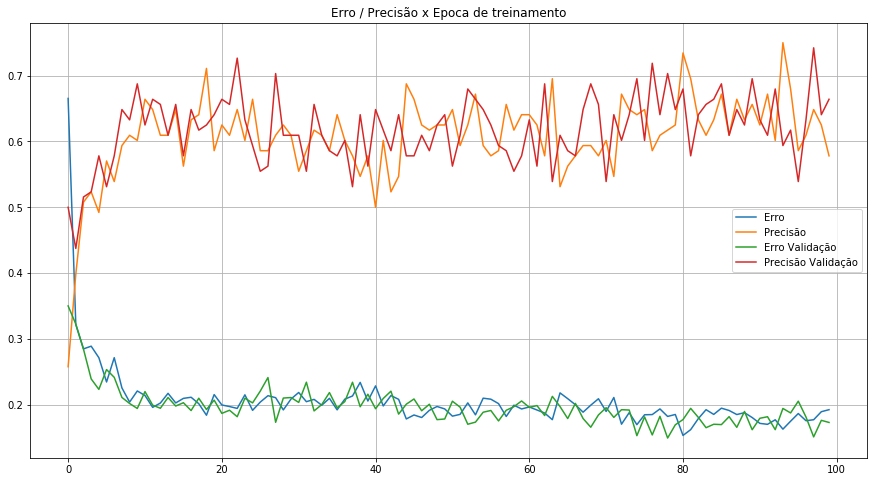

In [12]:
plt.figure(figsize=(15,8))
plt.title("Erro / Precisão x Epoca de treinamento")
plt.plot([np.sum(err) / len(err) for err in train_err], label='Erro');
plt.plot([np.sum(accu) / len(accu) for accu in train_accu], label='Precisão');
plt.plot([np.sum(err) / len(err) for err in eval_err], label='Erro Validação');
plt.plot([np.sum(accu) / len(accu) for accu in eval_accu], label='Precisão Validação');
plt.legend();
plt.grid();

Nota-se o processo de treinamento surtindo efeito sobre o erro médio e a precisão das predições do modelo. Nota-se ainda como o erro médio e precisão das amostras de teste seguem com proximidade as medidas das amostras de treinamento, indicando que não há processo de *overfiting* acontecendo. Falaremos mais sobre esse assunto mais a frente.

Demonstrada a complexidade de se implementar até mesmo um *Multilayer Perceptron* simples matematicamente com o numpy, vamos entender a implementação do mesmo modelo utilizando o Keras, o modulo de alto nível sobre o Tensorflow.

Iniciamos importando as dependencias e adquirimos o banco de dados.

In [13]:
from keras.layers import Dense, InputLayer
from keras.models import Sequential

# Adquire dados
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
sample = mnist.train.next_batch(1)

#VARIAVEIS DA DNN
n_in = sample[0].shape[1]      #numero de features de entrada, neste caso o numero de pixels da imagem
n_out = sample[1].shape[1]      #numero de saídas do grapho, neste caso 10 classes diferentes
n_samples = mnist.train.num_examples - 1     #numero de exemplos no dataset

Using TensorFlow backend.


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Feito isto, vamos instanciar nosso *Multilayer Perceptron*.

In [14]:
mlp = Sequential()
mlp.add(InputLayer(input_shape=(n_in,)))
mlp.add(Dense(n_hidden, activation='sigmoid'))
mlp.add(Dense(n_out, activation='sigmoid'))

mlp.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='sgd')

mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Isto é tudo. O codigo acima instancia e compila um *Multilayer Perceptron* simples. Utilizamos *Stochastic Gradient Descent* como algoritmo de otimização assim como anteriormente. Com o modelo ja instanciado, vamos realizar seu treinamento.

In [15]:
train_history = mlp.fit(mnist.train.images[::4], mnist.train.labels[::4], batch_size=128, epochs=100,
                        validation_data=[mnist.validation.images[::4], mnist.validation.labels[::4]], verbose=0)

O método *fit* realiza todo o trabalho de propagar os gradientes e atualizar os pesos do modelo para nós. Como parametros deste método, são especificados o tamanho da amostra, o número de épocas de treinamento e os dados de validação a serem utilizados. Este método retorna um objeto história de treinamento onde ficam gravados os dados de treinamento para análise posterior.

O código abaixo utiliza este objeto para plotar os dados de erro e precisão do treinamento

Precisão na última época de treino:  0.9005818181211298
Erro médio na última época de treino:  0.37407184601263566
Precisão na última época de validação:  0.864800000667572
Erro médio na última época de validação:  0.47731109623908996


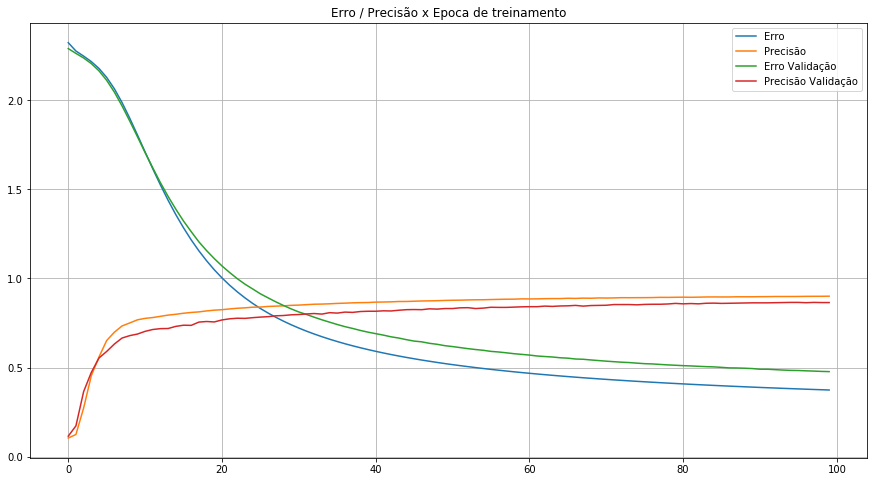

In [16]:
plt.figure(figsize=(15,8))
plt.title("Erro / Precisão x Epoca de treinamento")
plt.plot([err for err in train_history.history['loss']], label='Erro');
plt.plot([accu for accu in train_history.history['acc']], label='Precisão');
plt.plot([err for err in train_history.history['val_loss']], label='Erro Validação');
plt.plot([accu for accu in train_history.history['val_acc']], label='Precisão Validação');
plt.legend();
plt.grid();

print("Precisão na última época de treino: ", train_history.history['acc'][-1])
print("Erro médio na última época de treino: ", train_history.history['loss'][-1])
print("Precisão na última época de validação: ", train_history.history['val_acc'][-1])
print("Erro médio na última época de validação: ", train_history.history['val_loss'][-1])

Pode-se perceber que o Keras facilita muito a vida quando se trata de prototipar e testar grafos computacionais como redes neurais. Além disso, a implementação com *backend* em Tensorflow permite ao querar fazer uso da GPU como processador de matrizes, o que acelera o processamento em ordens de magnitude.

Não entraremos em detalhes sobre implementações em tensorflow por se tratar de baixo nível e fora do escopo desde manual. Contudo, muito material esta disponível na internet, a começar pela [documentação](https://www.tensorflow.org/) do Tensorflow, e faremos a cobertura deste assunto em um manual futuro.